In [23]:
import json
import math
import os
import pathlib
import re
from collections import defaultdict
import seaborn
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import textstat
from nltk.stem import *
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.svm import LinearSVC
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer as VS
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.pipeline import Pipeline

import warnings

def flesch_reading_ease(text):
    # formula=206.835-1.015(total_words/1)-84.6(syllables/total_words)
    syllables=textstat.syllable_count(text)
    words=textstat.lexicon_count(text, removepunct=True)
    score=round(206.835-1.015*(words/1)-84.6*(float(syllables/words)),2)
    # print(score)
    return score

def flesch_kincaid_grade_level(text):
    # formula=0.39*(total_words/1)+11.8(syllables/total_words)-15.59
    syllables=textstat.syllable_count(text)
    words=textstat.lexicon_count(text, removepunct=True)
    score=round(0.39*(words/1)+11.8*(syllables/words)-15.59,2)
    # print(score)
    return score

def total_characters(text):
    count=0
    for char in text:
        count += 1
    return count

#Remove extra white spaces, urls , mentions
def preprocess(text):
    text=text.lower()   
    # print(stopwords)
    space_pattern = '\s+'
    giant_url_regex = ('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|'
    '[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    mention_regex = '@[\w\-]+'
    parsed_text = re.sub(space_pattern, ' ', text)
    parsed_text = re.sub(giant_url_regex, '', parsed_text)
    parsed_text = re.sub(mention_regex, '', parsed_text)
    return parsed_text

def tokenization_with_stemming(text):
    stemmer=PorterStemmer()
    # """Removes punctuation & excess whitespace, sets to lowercase,
    # and stems tweets. Returns a list of stemmed tokens."""
    # text = " ".join(re.split("[^a-zA-Z]*", text.lower())).strip()
    tokens = [stemmer.stem(t) for t in text.split()]
    # print(tokens)

    return tokens

def tokenize(text):
    text = " ".join(re.split("[^a-zA-Z.,!?]*", text.lower())).strip()
    return text.split()

def set_class(text):
    if text=='NAG':
        return 2
    elif text=='OAG':
        return 1
    else:
        return 0

def preprocessing():
    path = pathlib.Path(__file__).parent.absolute()
    path = str(path)
    #Loading file set to data frame
    df=pd.read_csv(path + "\\trac-gold-set\\agr_en_tw_gold.csv", encoding = "utf-8")
    #Case folding and porter stemming
    # df["preprocess"]=df["text"].apply(lambda x:x.lower())
    df["preprocess"]=df["text"].apply(lambda x:preprocess(x))
    # print(df['preprocess'])
    df["flesch_reading_ease"]=df["text"].apply(lambda x:flesch_reading_ease(x))
    df["flesch_kincaid_grade_level"]=df["text"].apply(lambda x:flesch_kincaid_grade_level(x))
    df["syllables"]=df["text"].apply(lambda x:textstat.syllable_count(x))
    df["words"]=df["text"].apply(lambda x:textstat.lexicon_count(x))
    df["characters"]=df["text"].apply(lambda x:total_characters(x))
    df["class"]=df["aggresssion-level"].apply(lambda x:set_class(x))
    #Export processed CSV
    # print(df.text)
    df.to_csv('processed_data.csv')
    # df.describe()

def features(text):
    sentiment_analyzer=VS()
    sentiment = sentiment_analyzer.polarity_scores(text)
    
    words = preprocess(text) #Get text only
    syllables = textstat.syllable_count(words)
    num_chars = sum(len(w) for w in words)
    num_chars_total = len(text)
    num_terms = len(text.split())
    num_words = len(words.split())
    avg_syl = round(float((syllables+0.001))/float(num_words+0.001),4)
    num_unique_terms = len(set(words.split()))
    
    ###Modified FK grade, where avg words per sentence is just num words/1
    FKRA = flesch_kincaid_grade_level(text)
    ##Modified FRE score, where sentence fixed to 1
    FRE = flesch_reading_ease(text)
    features = [FKRA, FRE,syllables, avg_syl, num_chars, num_chars_total, num_terms, num_words,
                num_unique_terms, sentiment['neg'], sentiment['pos'], sentiment['neu'], sentiment['compound']]
    #features = pandas.DataFrame(features)
    return features

def get_feature_array(text):
    feats=[]
    for t in text:
        feats.append(features(t))
    return np.array(feats)

other_features_names = ["FKRA", "FRE","num_syllables", "avg_syllables_per_sent", "num_chars", "num_chars_total",
                        "num_terms", "num_words", "num_unique_words", "vader neg","vader pos","vader neu", 
                        "vader compound"]

stopwords = nltk.corpus.stopwords.words("english")
# preprocessing()
vectorizer = TfidfVectorizer(
    tokenizer=tokenization_with_stemming,
    preprocessor=preprocess,
    ngram_range=(1, 3),
    stop_words=stopwords,
    use_idf=True,
    smooth_idf=False,
    norm=None,
    decode_error='replace',
    max_features=10000,
    min_df=5,
    max_df=0.75
    )
warnings.simplefilter(action='ignore', category=FutureWarning)
df=pd.read_csv("output.csv")
text=df.text
tfidf = vectorizer.fit_transform(text).toarray()
vocab = {v:i for i, v in enumerate(vectorizer.get_feature_names())}
idf_vals = vectorizer.idf_
idf_dict = {i:idf_vals[i] for i in vocab.values()} #keys are indices; values are IDF scores
# print(idf_dict) 
# other_features=list()
features=get_feature_array(text)
# print(features)

#Get parts of speech tags for text and save as a string
text_tag = []
for t in text:
    tokens = tokenize(preprocess(t))
    tags = nltk.pos_tag(tokens)
    tag_list = [x[1] for x in tags]
    tag_str = " ".join(tag_list)
    text_tag.append(tag_str)

pos_vectorizer = TfidfVectorizer(
    tokenizer=None,
    lowercase=False,
    preprocessor=None,
    ngram_range=(1, 3),
    stop_words=None,
    use_idf=False,
    smooth_idf=False,
    norm=None,
    decode_error='replace',
    max_features=5000,
    min_df=5,
    max_df=0.75,
    )
pos = pos_vectorizer.fit_transform(pd.Series(text_tag)).toarray()
pos_vocab = {v:i for i, v in enumerate(pos_vectorizer.get_feature_names())}

M = np.concatenate([tfidf,pos,features],axis=1)
# print(M.shape)
#Finally get a list of variable names
variables = ['']*len(vocab)
for k,v in vocab.items():
    variables[v] = k

pos_variables = ['']*len(pos_vocab)
for k,v in pos_vocab.items():
    pos_variables[v] = k

feature_names = variables+pos_variables+other_features_names
X = pd.DataFrame(M)
print (M)
y = df['class'].astype(int)
param_grid = [{}] # Optionally add parameters here
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

C:\Python\Python39\lib\site-packages\sklearn\feature_extraction\text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'becaus', 'befor', 'doe', 'dure', 'ha', 'hi', "it'", 'onc', 'onli', 'ourselv', "she'", "should'v", 'themselv', 'thi', 'veri', 'wa', 'whi', "you'r", "you'v", 'yourselv'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '
[[ 0.      0.      0.     ...  0.108   0.892   0.3182]
 [ 0.      0.      0.     ...  0.09    0.781  -0.25  ]
 [ 0.      0.      0.     ...  0.      1.      0.    ]
 ...
 [ 0.      0.      0.     ...  0.209   0.791   0.7003]
 [ 0.      0.      0.     ...  0.31    0.69    0.5563]
 [ 0.      0.      0.     ...  0.101   0.799   0.    ]]


In [24]:
pipe = Pipeline(
        [('select', SelectFromModel(LogisticRegression(solver='newton-cg',class_weight='balanced',
                                                  penalty="l2", C=0.01))),
        ('model', LogisticRegression(solver='newton-cg',class_weight='balanced',penalty='l2'))])
param_grid = [{}] # Optionally add parameters here
grid_search = GridSearchCV(pipe, 
                           param_grid,
                           cv=StratifiedKFold(n_splits=5).split(X_train, y_train), 
                           verbose=2)

In [25]:
model = grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END .................................................... total time=   0.3s
[CV] END .................................................... total time=   0.4s
[CV] END .................................................... total time=   0.4s
[CV] END .................................................... total time=   0.4s
[CV] END .................................................... total time=   0.4s


In [26]:
y_preds = model.predict(X_test)

In [27]:
report = classification_report( y_test, y_preds )

In [28]:
print(report)

              precision    recall  f1-score   support

           0       0.29      0.58      0.39        12
           1       0.29      0.40      0.33        15
           2       0.79      0.57      0.66        65

    accuracy                           0.54        92
   macro avg       0.45      0.52      0.46        92
weighted avg       0.64      0.54      0.57        92



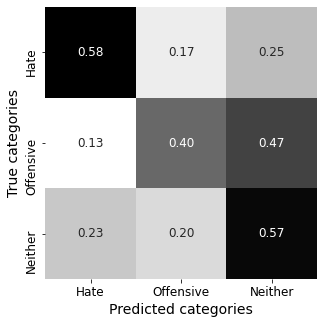

In [29]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test,y_preds)
matrix_proportions = np.zeros((3,3))
for i in range(0,3):
    matrix_proportions[i,:] = confusion_matrix[i,:]/float(confusion_matrix[i,:].sum())
names=['Hate','Offensive','Neither']
confusion_df = pd.DataFrame(matrix_proportions, index=names,columns=names)
plt.figure(figsize=(5,5))
seaborn.heatmap(confusion_df,annot=True,annot_kws={"size": 12},cmap='gist_gray_r',cbar=False, square=True,fmt='.2f')
plt.ylabel(r'True categories',fontsize=14)
plt.xlabel(r'Predicted categories',fontsize=14)
plt.tick_params(labelsize=12)

#Uncomment line below if you want to save the output
#plt.savefig('confusion.pdf')